In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import matplotlib.pyplot as plt

In [91]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

In [2]:
tnp.experimental_enable_numpy_behavior()

## piece-wise linear regression

* 이제까지는 단순선형회귀에 대해서 다루었다면 일정한 지점에서 절단점을 가지는 piecc-wise linear regreesion을 다루어보자

$$y = x + 0.3\varepsilon \quad x\leq 0$$

$$y = 3.5x + 0.3\varepsilon$$

In [63]:
np.random.seed(2021025)

N = 100

x = np.linspace(-1,1,N)
e = np.random.normal(size=N)

y = list(map(lambda x,e : x + 0.3*e if x<=0 else 3.5*x +0.3*e,x,e))
y = np.array(y)

#### 시각화

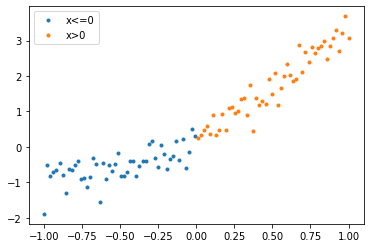

In [65]:
plt.plot(x[x<=0],y[x<=0],".")
plt.plot(x[x>0],y[x>0],".")
plt.legend(["x<=0", "x>0"])

#### 풀이 1

* tip : `x,y`가 `tensor`가 아니어도 신경망 적합시 잘 적합된다.

In [68]:
x = x.reshape(N,1)
y = y.reshape(N,1)

In [69]:
net = tf.keras.Sequential()
layer = tf.keras.layers.Dense(1)
net.add(layer)

net.compile(tf.optimizers.SGD(0.1),loss = "mse")
net.fit(x,y,batch_size=N,verbose=0,epochs=1000)

In [71]:
w = net.weights

In [77]:
beta0, beta1 = w[1],w[0]

In [87]:
yhat = x*beta1+beta0
yhat = yhat.reshape(N,)

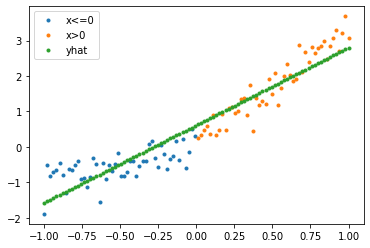

In [89]:
plt.plot(x[x<=0],y[x<=0],".")
plt.plot(x[x>0],y[x>0],".")
plt.plot(x,yhat,".")
plt.legend(["x<=0", "x>0","yhat"])

* 위 적합한 모형은 틀렸음

* 우리가 의도한 모델은 피스와이즈 모델이지 단순선형모델이 아님 $\to$ 꺽은선 형태의 모델이 형성되어야 한다.

* 위 같은 문제를 `underfit` 의 문제라고 함.

#### 풀이 2. 비선형 활성화 함수의 도입(Relu)

`Relu`

$$relu(x) = max(0,x)$$

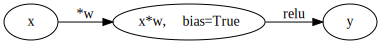

In [92]:
#collapse
gv('''
"x" -> "x*w,    bias=True"[label="*w"] ;
"x*w,    bias=True" -> "y"[label="relu"] ''')

* 즉, $x$가 0보다 작은 녀석들은 전부다 0으로 보내는 활성화함수이다.

In [95]:
net2 = tf.keras.Sequential()

l1 = tf.keras.layers.Dense(1,input_shape=(1,))

a1 = tf.keras.layers.Activation(tf.nn.relu)

net2.add(l1)
net2.add(a1)

*  l1의 weight($\beta_1$)값이 1보다 크게 나와야 현재 보여주려는 문제 의도대로 풀 수 있다.

In [99]:
l1.weights

[<tf.Variable 'dense_3/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.47527015]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

* 현재 생성한 네트워크 상황을 확인해보자.

In [100]:
u1 = l1(x)
v1 = a1(u1)

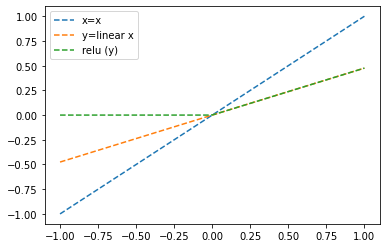

In [105]:
plt.plot(x,x,"--")
plt.plot(x,u1,"--")
plt.plot(x,v1,"--")
plt.legend(["x=x","y=linear x","relu (y)"])

* 오 표현하려는 relu 함수처럼 잘 표시된 것 같다.

이제 모델을 컴파일 하고 적합해보자!!

In [109]:
net2.compile(tf.optimizers.SGD(0.1),loss="MSE")
net2.fit(x,y,N,1000,0)

In [115]:
yhat = net2(x)
yhat = yhat.reshape(N,) ## 이건 굳이 안해줘도 되나 습관화하자 (목적에 맞게 차원변환)

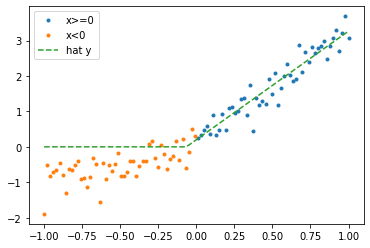

In [118]:
plt.plot(x[x>=0],y[x>=0],".",label="x>=0")
plt.plot(x[x<0],y[x<0],".",label="x<0")
plt.plot(x,yhat,"--",label="hat y")
plt.legend()

* 그런데... 아직도 $x<0$인 부분에서는 모델 적합이 잘 되지 않은 것 같다.

* why? relu 함수의 특성상 $relu(y) = 0, (y<0)$ 으로 전부 보냈기 때문!

* 이제 선형변환된 값들이 0 이하로 떨어지는 부분들을 어떻게 하면 잘 적합시킬 수 있는지 해결하자!

* 해결책 : $\hat {y}$ 가 2개가 있으면? 

#### 풀이 3

* 목표 : $\hat y$를 2개 만들자,즉 $\hat y \to (N,2)$

* 위의 의도대로 하려면 하나의 $\bf X$를 받아 2개의 출력이 나와야한다!!

In [351]:
net3 = tf.keras.Sequential()

l1 = tf.keras.layers.Dense(2,input_shape=(1,))
a1 = tf.keras.layers.Activation(tf.nn.relu)

net3.add(l1)
net3.add(a1)

(현재 네트워크 상황 확인)

In [352]:
l1.weights

[<tf.Variable 'dense_50/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[-1.1642166,  0.6747991]], dtype=float32)>,
 <tf.Variable 'dense_50/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

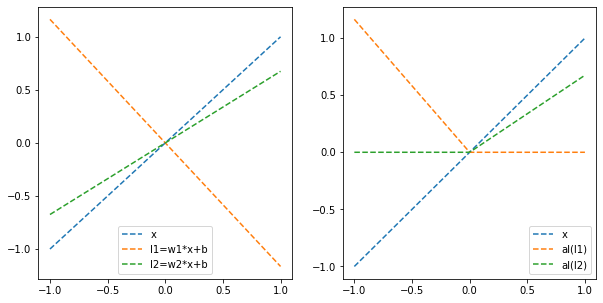

In [353]:
## collapse
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.plot(x,x,"--")
ax1.plot(x,l1(x),"--")
ax1.legend(["x","l1=w1*x+b","l2=w2*x+b"])

ax2.plot(x,x,"--")
ax2.plot(x,a1(l1(x)),"--")
ax2.legend(["x","al(l1)","al(l2)"])

* 위의 문제점

`1`. 우리의 의도대로 `relu`를 지나서 $\hat y$ 를 2차원으로 만들었다..

`2`. 근데 차피 `relu`를 지나면 `al(l1),al(l2)`가 0보다 작으면 $\hat y$는 전부 0이 나올 것임

`3`. 해결책 : 노드를 추가해서 `al(l1),al(l2)`를 입력으로 받아 선형모형을 다시 만들자

`4`. 또한 $\hat y$의 차원의 수를 의도적으로 2차원으로 만들었으니 다시 1차원으로 변경해주자!

  * 즉, 입력차원 2, 출력차원 1로 변환해주는 노드를 추가

python
```
temp  = tf.keras.Sequential()
_l1 = tf.keras.layers.Dense(2,input_shape=(1,))
_a1 = tf.keras.layers.Activation(tf.nn.relu)
_l2 = tf.keras.layers.Dense(2,input_shape=(2,))

temp.add(_l1)
temp.add(_a1)
temp.add(_l2)
````

In [354]:
temp.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 2)                 4         
                                                                 
 activation_15 (Activation)  (None, 2)                 0         
                                                                 
 dense_27 (Dense)            (None, 2)                 6         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [355]:
l2 = tf.keras.layers.Dense(1,input_shape=(2,))

In [356]:
net3.add(l2)

In [357]:
l2.weights

[<tf.Variable 'dense_51/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.54625785],
        [ 0.949442  ]], dtype=float32)>,
 <tf.Variable 'dense_51/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [358]:
net3.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 2)                 4         
                                                                 
 activation_28 (Activation)  (None, 2)                 0         
                                                                 
 dense_51 (Dense)            (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [359]:
net3.compile(tf.optimizers.SGD(0.1),loss="mse")
net3.fit(x,y,N,1000,0)

In [360]:
yhat = net3(x)
yhat = yhat.reshape(N,)

(네트워크의 변화과정 확인)

In [361]:
l1_1=l1(x)[:,[0]].reshape(N,)
l1_2=l1(x)[:,[1]].reshape(N,)

In [362]:
l2.weights

[<tf.Variable 'dense_51/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.734917 ],
        [ 1.8227489]], dtype=float32)>,
 <tf.Variable 'dense_51/bias:0' shape=(1,) dtype=float32, numpy=array([-0.05703843], dtype=float32)>]

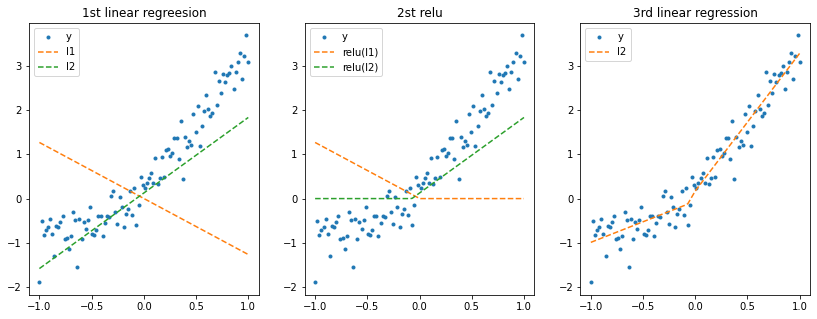

In [363]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_figwidth(14b)
fig.set_figheight(5)

ax1.plot(x,y,".")
ax1.plot(x,l1_1,"--")
ax1.plot(x,l1_2,"--")
ax1.legend(["y","l1","l2"])
ax1.set_title("1st linear regreesion")

ax2.plot(x,y,".")
ax2.plot(x,a1(l1(x)),"--")
ax2.set_title("2st relu")
ax2.legend(["y","relu(l1)","relu(l2)"])

ax3.plot(x,y,".")
ax3.plot(x,l2(a1(l1(x))),"--")
ax3.set_title("3rd linear regression")
ax3.legend(["y","l2"])

* 표본의 수가 작아서 그런가 의도한대로 잘 안나오다가 한 10번 돌려서 나온 것 같음..

* 즉. 여기까지 요약하자면

* 2개의 출력을 가지는 linear $\to$ relu $\to$ 1차원의 linear

* 근데 풀이 3의 실패하는 경우도 존재함.

In [394]:
np.random.seed(4)
N = 100

x = np.linspace(-1,1,N)
e = np.random.normal(size=N)

y = list(map(lambda x,e : x + 0.3*e if x<=0 else 3.5*x +0.3*e,x,e))
y = np.array(y)

x= x.reshape(N,1)
y= y.reshape(N,1)

In [395]:
tf.random.set_seed(2)

net3 = tf.keras.Sequential()
####
net3.add(tf.keras.layers.Dense(2))
net3.add(tf.keras.layers.Activation("relu"))
net3.add(tf.keras.layers.Dense(1))
####
net3.compile(optimizer = tf.optimizers.SGD(0.1),loss="mse")

net3.fit(x,y,epochs=1000,verbose=0,batch_size=N)

In [400]:
l2.weights

[<tf.Variable 'dense_51/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.734917 ],
        [ 1.8227489]], dtype=float32)>,
 <tf.Variable 'dense_51/bias:0' shape=(1,) dtype=float32, numpy=array([-0.05703843], dtype=float32)>]

* 그냥 이거는 교수님 코드 따라서 친건데 밑에 그래프하고 똑같음

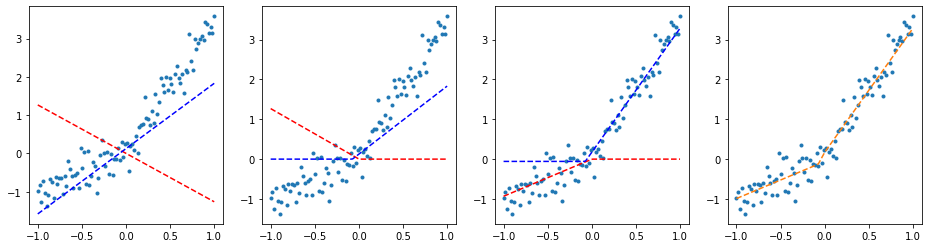

In [406]:
#collapse
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
fig.set_figwidth(16) 
ax1.plot(x,y,'.')
ax1.plot(x,l1(x)[:,0],'--r')
ax1.plot(x,l1(x)[:,1],'--b')
ax2.plot(x,y,'.')
ax2.plot(x,a1(l1(x))[:,0],'--r')
ax2.plot(x,a1(l1(x))[:,1],'--b')
ax3.plot(x,y,'.')
ax3.plot(x,a1(l1(x))[:,0]*(-0.734917),'--r')
ax3.plot(x,a1(l1(x))[:,1]*(1.8227489)+(-0.05703843),'--b')
ax4.plot(x,y,'.')
ax4.plot(x,a1(l1(x))[:,0]*(-0.734917)+a1(l1(x))[:,1]*(1.8227489)+(-0.05703843),'--')

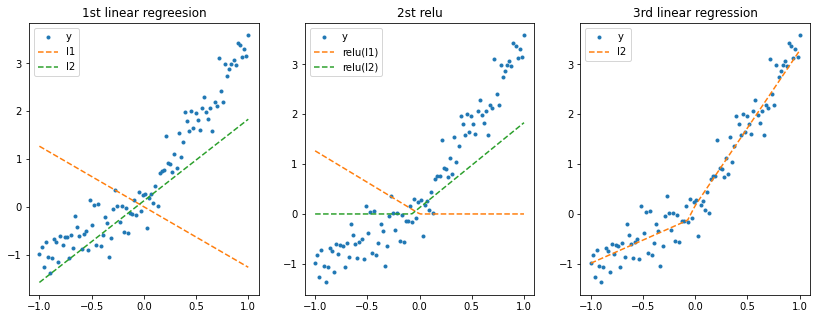

In [405]:
#collapse
fig,(ax1,ax2,ax3) = plt.subplots(1,3)

fig.set_figwidth(14)
fig.set_figheight(5)

ax1.plot(x,y,".")
ax1.plot(x,l1_1,"--")
ax1.plot(x,l1_2,"--")
ax1.legend(["y","l1","l2"])
ax1.set_title("1st linear regreesion")

ax2.plot(x,y,".")
ax2.plot(x,a1(l1(x)),"--")
ax2.set_title("2st relu")
ax2.legend(["y","relu(l1)","relu(l2)"])

ax3.plot(x,y,".")
ax3.plot(x,l2(a1(l1(x))),"--")
ax3.set_title("3rd linear regression")
ax3.legend(["y","l2"])

* 사실 위 경우는 2개의 linear가 둘 다 일을 잘하고 있는 것임

* 근데 가끔 둘 중에 한 개가 일을 제대로 하지 못하는 경우가 발생 (예를 들어 선형변환된 선중에 하나가 계속 0값을 가지면?)

* 즉, 현재 학습한 에포크에서 우리가 만든 모델이 최적상태이다. $\to$ 완전한 예측은 난 못해 이런느낌

* 이를 `global minimum(로스를 최소하는)`을 찾지 못하고 `local minimum(현재 조건에서 최적화한)`에 빠졌다고 한다.

* 7주차 공부한 `피스와이즈`는  `DNN` 이라고 할 수 있다.

## logistic 

* 결론부터 말하자면 로지스틱은 `MSE`대신 `BCE`(Binary cross entropy)를 손실함수로 사용한다.

* 왜? 로지스틱의 손실함수 BCE인 경우 convex(2차함수모양)하기 때문에 글로벌 미니멈을 잘 찾을 수 있음!!

### 예제

In [496]:
N = 2000

x = np.linspace(-1,1,N).reshape(N,1)

초기 가중치 설정 및 베르누이 분포

In [409]:
w0 = -1
w1 = 5

u = w0+x*w1

v = tf.nn.sigmoid(u)
y = tf.constant(np.random.binomial(1,v))

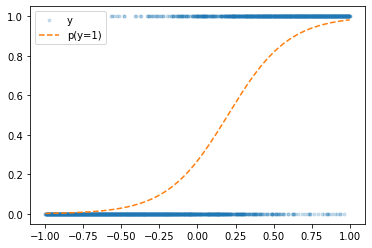

In [413]:
plt.plot(x,y,".",alpha=0.2)
plt.plot(x,v,"--")
plt.legend(["y","p(y=1)"])

#### 케라스를 이용하여 구현

In [440]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1,input_shape=(1,),activation="sigmoid"))
net.compile(tf.optimizers.SGD(0.1),loss='binary_crossentropy' )

In [441]:
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

Text(0.5, 1.0, 'with keras')

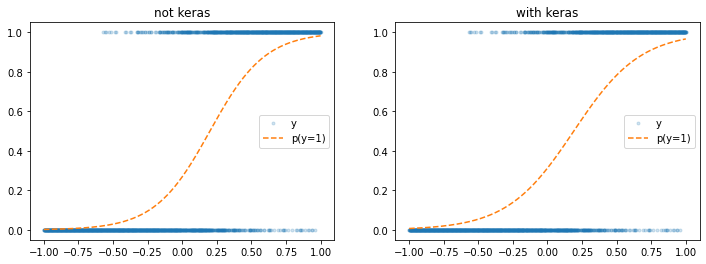

In [442]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(12)

ax1.plot(x,y,".",alpha=0.2)
ax1.plot(x,v,"--")
ax1.legend(["y","p(y=1)"])
ax1.set_title("not keras")

ax2.plot(x,y,".",alpha=0.2)
ax2.plot(x,net(x),"--")
ax2.legend(["y","p(y=1)"])
ax2.set_title("with keras")


#### MSE vs BCE

In [443]:
net2 = tf.keras.Sequential()
net2.add(tf.keras.layers.Dense(1,input_shape=(1,),activation="sigmoid"))
net2.compile(tf.optimizers.SGD(0.1),loss='mse' )

In [445]:
net2.fit(x,y,epochs=1000,verbose=0,batch_size=N)

Text(0.5, 1.0, 'BCE vs MSE')

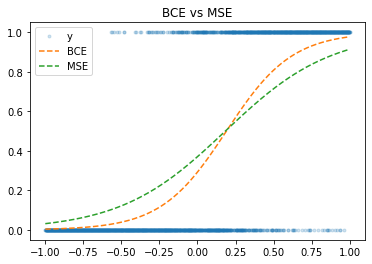

In [446]:
plt.plot(x,y,".",alpha=0.2)
plt.plot(x,net(x),"--")
plt.plot(x,net2(x),"--")
plt.legend(["y","BCE","MSE"])
plt.title("BCE vs MSE")

* 로지스틱 회귀모형의 특성상 $x$는 0을 기점으로 약간 지그재그에 가까울수록 좋은 모형인데

* `BCE`가 확실히 `MSE`에 비해서 지그재그에 가까워 보인다!

* 즉 BCE는 동일한 조건(epoch,가중치)에서 `BCE`가 `MSE`보다 적합이 뛰어나다.

##### MSE, BCE loss 비교

In [502]:
mseloss_fn = lambda y,yhat: tf.reduce_mean((y-yhat)**2)
bceloss_fn = lambda y,yhat: -tf.reduce_mean(y*tnp.log(yhat) + (1-y)*tnp.log(1-yhat))

In [503]:
def loss_fn1(w0,w1):
    u = w0+w1*x 
    yhat = np.exp(u)/(np.exp(u)+1)
    return mseloss_fn(y,yhat) 

def loss_fn2(w0,w1):
    u = w0+w1*x 
    yhat = np.exp(u)/(np.exp(u)+1)
    return bceloss_fn(y,yhat)

In [512]:
w0, w1 = np.meshgrid(np.arange(-10,3,0.2), np.arange(-1,10,0.2), indexing='ij')
w0, w1 = w0.reshape(-1), w1.reshape(-1)


loss1 = list(map(loss_fn1,w0,w1))
loss2 = list(map(loss_fn2,w0,w1))

In [532]:
w0.shape,w1.shape

((3575,), (3575,))

Text(0.5, 0.92, 'BCE Loss')

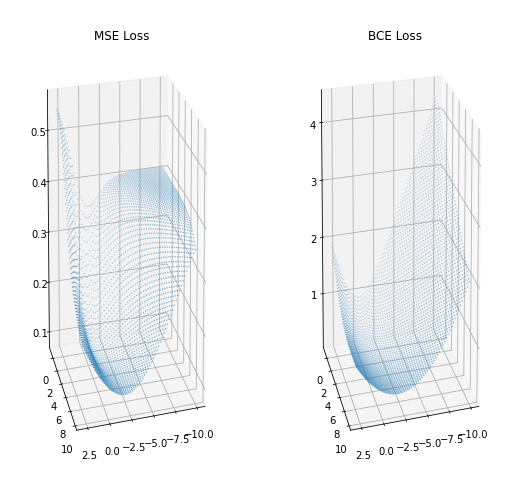

In [530]:
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(9)
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.elev=15
ax2.elev=15
ax1.azim=75
ax2.azim=75
ax1.scatter(w0,w1,loss1,s=0.1)
ax1.set_title("MSE Loss")
ax2.scatter(w0,w1,loss2,s=0.1) 
ax2.set_title("BCE Loss")

* 로스를 확인한 결과 오른쪽 그림이 더 최적해에 잘 수렴할 것 같음

* 이번엔 동일한 기준을 설정해놓고 확인해보자.

`-` 파라미터 : (w0,w1) = (-3.0,1.0), epoch 15 마다 관찰

In [543]:
x.shape

(2000, 1)

In [546]:
tf.ones(N,dtype=tf.float64).reshape(N,1)

<tf.Tensor: shape=(2000, 1), dtype=float64, numpy=
array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])>

In [549]:
X = tf.concat([tf.ones(N,dtype=tf.float64).reshape(N,1),x],axis=1)

In [584]:
X.shape

TensorShape([2000, 2])

In [606]:
net1 = tf.keras.Sequential()
net1.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid')) 
net1.compile(tf.keras.optimizers.SGD(0.1),loss="mse")
net1.fit(X,y,N,1,0)

In [607]:
net2 = tf.keras.Sequential()
net2.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid')) 
net2.compile(tf.keras.optimizers.SGD(0.1),loss="binary_crossentropy")
net2.fit(X,y,N,1,0)

* 에포크 한번 안덜리면 `set_weights`못함...

In [610]:
net1.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])
net2.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])

In [611]:
net_mse.get_weights(), net_bce.get_weights()

([array([[-3.],
         [-1.]], dtype=float32)], [array([[-3.],
         [-1.]], dtype=float32)])

이제 `15 epoch`마다 기록해보자

In [613]:
mse_hat = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)
bce_hat = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)

In [616]:
tf.concat([mse_hat,bce_hat],axis=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-3., -3.],
       [-1., -1.]], dtype=float32)>

In [621]:
net1.weights[0]

<tf.Variable 'dense_116/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-1.4075234 ],
       [ 0.26052466]], dtype=float32)>

In [619]:
for i in range(29) :
    net1.fit(X,y,N,15,0)
    net2.fit(X,y,N,15,0)
    mse_hat = tf.concat([mse_hat,net1.weights[0]],axis=1)
    bce_hat = tf.concat([bce_hat,net2.weights[0]],axis=1)

##### 시각화

In [622]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [625]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
fig.suptitle("SGD, Winit=(-3,-1)")
ax1=fig.add_subplot(2,2,1,projection='3d')
ax2=fig.add_subplot(2,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(w0,w1,loss1,s=0.1);ax1.scatter(-1,5,loss_fn1(-1,5),color='red',marker='*',s=200)
ax2.scatter(w0,w1,loss2,s=0.1);ax2.scatter(-1,5,loss_fn2(-1,5),color='red',marker='*',s=200)

ax3.plot(x,y,','); ax3.plot(x,v,'--r'); 
line3, = ax3.plot(x,1/(1+np.exp(-X@mse_hat[:,0])),'--b')
ax3.set_title("MSE")
ax4.plot(x,y,','); ax4.plot(x,v,'--r')
line4, = ax4.plot(x,1/(1+np.exp(-X@bce_hat[:,0])),'--b')
ax4.set_title("BCE")
def animate(i):
    _w0_mse,_w1_mse = mse_hat[:,i]
    _w0_bce,_w1_bce = bce_hat[:,i]
    ax1.scatter(_w0_mse, _w1_mse, loss_fn1(_w0_mse, _w1_mse),color='gray')
    ax2.scatter(_w0_bce, _w1_bce, loss_fn2(_w0_bce, _w1_bce),color='gray')
    line3.set_ydata(1/(1+np.exp(-X@mse_hat[:,i])))
    line4.set_ydata(1/(1+np.exp(-X@bce_hat[:,i])))

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

* MSE의 경우 초기 기울기가 크지 않아 loss가 0으로 가는 속도가 매우 느리다.

* 즉 동일한 기준에서 BCE loss가 성능이 더좋다!!

##### Adam 옵티마이저

In [626]:
net_mse = tf.keras.Sequential()
net_mse.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid')) 
net_mse.compile(optimizer=tf.optimizers.Adam(0.1),loss=mseloss_fn) 
net_mse.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 438ms/step - loss: 0.3187


In [627]:
net_bce = tf.keras.Sequential()
net_bce.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid')) 
net_bce.compile(optimizer=tf.optimizers.Adam(0.1),loss=bceloss_fn) 
net_bce.fit(X,y,epochs=1,batch_size=N)

1/1 [==============================] - 0s 495ms/step - loss: 0.8539


In [628]:
net_mse.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])
net_bce.set_weights([tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)])

In [629]:
What_mse = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)
What_bce = tnp.array([[-3.0 ],[ -1.0]],dtype=tf.float32)

In [630]:
for k in range(29): 
    net_mse.fit(X,y,epochs=15,batch_size=N,verbose=0)
    net_bce.fit(X,y,epochs=15,batch_size=N,verbose=0)
    What_mse = tf.concat([What_mse,net_mse.weights[0]],axis=1) 
    What_bce = tf.concat([What_bce,net_bce.weights[0]],axis=1)

In [633]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
fig.suptitle("Adam, Winit=(-3,-1)")
ax1=fig.add_subplot(2,2,1,projection='3d')
ax2=fig.add_subplot(2,2,2,projection='3d')
ax1.elev=15;ax2.elev=15;ax1.azim=75;ax2.azim=75
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

ax1.scatter(w0,w1,loss1,s=0.1);ax1.scatter(-1,5,loss_fn1(-1,5),color='red',marker='*',s=200)
ax2.scatter(w0,w1,loss2,s=0.1);ax2.scatter(-1,5,loss_fn2(-1,5),color='red',marker='*',s=200)

ax3.plot(x,y,','); ax3.plot(x,v,'--r'); 
line3, = ax3.plot(x,1/(1+np.exp(-X@What_mse[:,0])),'--b')
ax4.plot(x,y,','); ax4.plot(x,v,'--r')
line4, = ax4.plot(x,1/(1+np.exp(-X@What_bce[:,0])),'--b')

def animate(i):
    _w0_mse,_w1_mse = What_mse[:,i]
    _w0_bce,_w1_bce = What_bce[:,i]
    ax1.scatter(_w0_mse, _w1_mse, loss_fn1(_w0_mse, _w1_mse),color='gray')
    ax2.scatter(_w0_bce, _w1_bce, loss_fn2(_w0_bce, _w1_bce),color='gray')
    line3.set_ydata(1/(1+np.exp(-X@What_mse[:,i])))
    line4.set_ydata(1/(1+np.exp(-X@What_bce[:,i])))

ani = animation.FuncAnimation(fig, animate, frames=30)
plt.close()
ani

Output hidden; open in https://colab.research.google.com to view.

* `Adam`의 경우 손실함수 미분시 자동으로 `scale`을 조정해주고 계산된 기울기 값을 누적시켜 반영하기 때문에 잘 적합됨을 보인다.

* 그렇다고 손실함수 상관없이 `Adam`을 무조건으로 선호하면 안된다.

* 아무리 `Adam`이라고 해도 초기값 설정이 좋지 않으면 로컬미니멈에서 빠져나오기 힘들다.

* 따라서 경우에 맞게 일차적으로 손실함수를 결정한 후 그 후에 옵티마이저를 결정하는 것이 옳은 판단!!